In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from tqdm.notebook import tqdm
from IPython.display import clear_output
import os, shutil, gc
import torch
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import ecdf

# proper order of our reference models
REF_MODELS = [
    "Yi-1.5-9B-Chat",
    "Meta-Llama-3.1-8B-Instruct",
    "Phi-3-medium-128k-instruct",
    "Mistral-7B-Instruct-v0.3",
    "Qwen2.5-0.5B-Instruct",
    "Qwen2.5-1.5B-Instruct",
    "Qwen3-4B-Instruct-2507"
    ]

# truncated to match dataframes
REF_MODELS_TRUNC = [
    "Yi-1.5-9B",
    "Llama-3.1-8B",
    "Phi-3-Medium-128k",
    "Mistral-7B",
    "Qwen2.5-0.5B",
    "Qwen2.5-1.5B",
    "Qwen3-4B"
    ]

# Figure 1: Test Accuracies By Method and Dataset

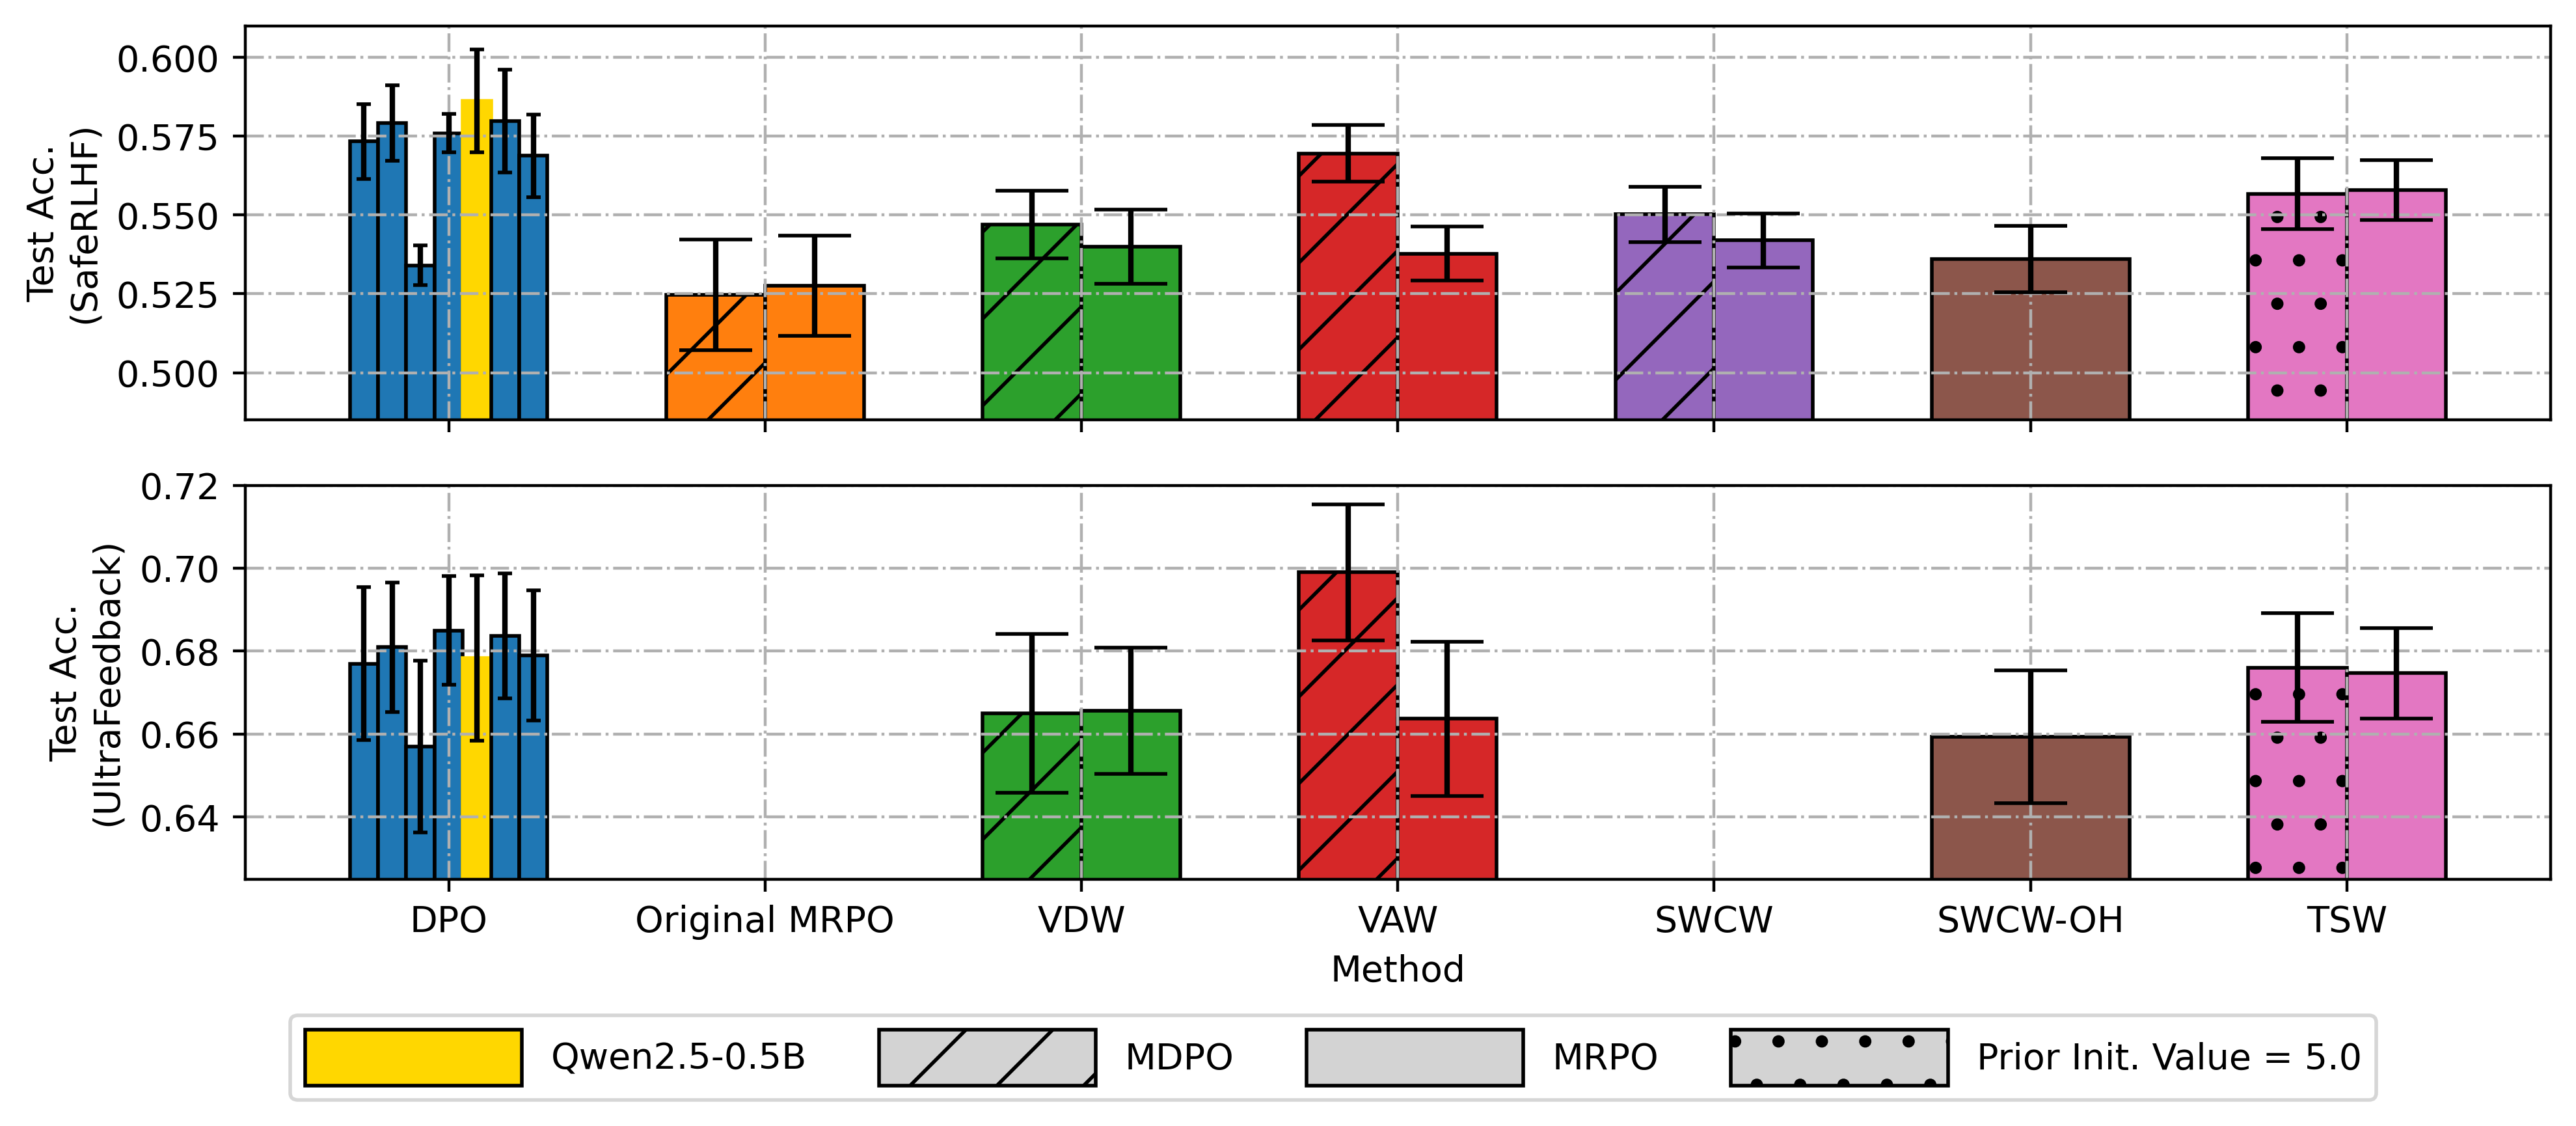

In [ ]:
'''
Order: DPO (7x), Original MRPO/MDPO, VDW MRPO/MDPO, VAW MRPO/MDPO, SWCW MRPO/MDPO, SWCW-OH, TSW 5.0/10.0
'''
# create our long subplots
fig, ax = plt.subplots(2, 1, dpi=400, figsize=(10, 4), sharex=True)

# go thru each dataset
for i, dataset in enumerate(["SafeRLHF", "UltraFeedback"]):

    # 1. assemble the mean accuracies and standard errors for each method

    ## DPO
    dpo_query = pd.read_csv("cleaned_results/dpo_summary.csv").groupby(["method", "dataset", "reference"])
    dpo_means = dpo_query.mean().reset_index().query(f"dataset == '{dataset}'")\
    .set_index("reference").loc[REF_MODELS_TRUNC].final_test_acc.values
    dpo_stds = dpo_query.std().reset_index().query(f"dataset == '{dataset}'")\
    .set_index("reference").loc[REF_MODELS_TRUNC].final_test_acc.values
    dpo_stderrs = dpo_stds / np.sqrt(5 if dataset == "SafeRLHF" else 3)

    # plot DPO with its error bars
    bars = ax[i].bar(x=np.arange(-3, 3+1) / 14, height=dpo_means, width=1/14,
              yerr=dpo_stderrs, capsize=2, edgecolor="black")
    bars[-3].set_color("gold")

    ## Original MDPO/MRPO
    if dataset == "SafeRLHF":

        # we're only doing this for SafeRLHF because UltraFeedback NaN'ed out.
        originals_query = pd.read_csv("cleaned_results/originals_summary.csv")\
        .groupby(["method", "dataset", "base"])
        originals_means = originals_query.mean().final_test_acc.values # order is MDPO/MRPO.
        originals_stds = originals_query.std().final_test_acc.values
        originals_stderrs = originals_stds / np.sqrt(3)

        # plot the original method
        bars = ax[i].bar(x=np.array([-0.125, +0.125]) + (0.8*1), height=originals_means, width=0.25,
                  yerr=originals_stderrs, capsize=10, edgecolor="black")
        bars[0].set_hatch("/")

    else:
        # put in a dummy
        ax[i].bar(x=[0.8*1], height=[np.nan])

    ## VDW MRPO/MDPO (Offline 1)
    vdw_query = pd.read_csv("cleaned_results/offlines_summary.csv")\
    .query(f"dataset == '{dataset}' and method == 'VDW'").groupby(["method", "dataset", "base"])
    vdw_means = vdw_query.mean().final_test_acc.values
    vdw_stds = vdw_query.std().final_test_acc.values
    vdw_stderrs = vdw_stds / np.sqrt(5 if dataset == "SafeRLHF" else 3)
    bars = ax[i].bar(x=np.array([-0.125, +0.125]) + (0.8*2), height=vdw_means, width=0.25,
              yerr=vdw_stderrs, capsize=10, edgecolor="black")
    bars[0].set_hatch("/")

    ## VAW MRPO/MDPO (Offline 2)
    vaw_query = pd.read_csv("cleaned_results/offlines_summary.csv")\
    .query(f"dataset == '{dataset}' and method == 'VAW'").groupby(["method", "dataset", "base"])
    vaw_means = vaw_query.mean().final_test_acc.values
    vaw_stds = vaw_query.std().final_test_acc.values
    vaw_stderrs = vaw_stds / np.sqrt(5 if dataset == "SafeRLHF" else 3)
    bars = ax[i].bar(x=np.array([-0.125, +0.125]) + (0.8*3), height=vaw_means, width=0.25,
              yerr=vaw_stderrs, capsize=10, edgecolor="black")
    bars[0].set_hatch("/")

    ## SWCW MRPO/MDPO (Online 1)
    if dataset == "SafeRLHF":

        # Online 1 only worked on SafeRLHF! UltraFeedback NaN'ed out.
        swcw_query = pd.read_csv("cleaned_results/online-1s_summary.csv")\
        .query(f"dataset == '{dataset}' and one_hot == False").groupby(["method", "dataset", "base"])
        swcw_means = swcw_query.mean().final_test_acc.values
        swcw_stds = swcw_query.std().final_test_acc.values
        swcw_stderrs = swcw_stds / np.sqrt(5 if dataset == "SafeRLHF" else 3)
        bars = ax[i].bar(x=np.array([-0.125, +0.125]) + (0.8*4), height=swcw_means, width=0.25,
              yerr=swcw_stderrs, capsize=10, edgecolor="black")
        bars[0].set_hatch("/")

    # put a dummy
    else:
        ax[i].bar(x=[0.8*4], height=[np.nan])

    ## SWCW-OH (Online 1, One-Hot Encoded) - only one variant!
    swcw_oh_query = pd.read_csv("cleaned_results/online-1s_summary.csv")\
    .query(f"dataset == '{dataset}' and one_hot == True").groupby(["method", "dataset", "base"])
    swcw_oh_means = swcw_oh_query.mean().final_test_acc.values
    swcw_oh_stds = swcw_oh_query.std().final_test_acc.values
    swcw_oh_stderrs = swcw_oh_stds / np.sqrt(5 if dataset == "SafeRLHF" else 3)
    ax[i].bar(x=[0.8*5], height=swcw_oh_means, width=0.5,
              yerr=swcw_oh_stderrs, capsize=10, edgecolor="black")

    ## Thompson (Online 2)
    tsw_query = pd.read_csv("cleaned_results/tsw_summary.csv").query(f"dataset == '{dataset}'").groupby(["method", "dataset", "piv"])
    tsw_means = tsw_query.mean().final_test_acc.values
    tsw_stds = tsw_query.std().final_test_acc.values
    tsw_stderrs = tsw_stds / np.sqrt(5 if dataset == "SafeRLHF" else 3)
    bars = ax[i].bar(x=np.array([-0.125, +0.125]) + (0.8*6), height=tsw_means, width=0.25,
                     yerr=tsw_stderrs, capsize=10, edgecolor="black")
    bars[0].set_hatch(".")

    # 2. beautify
    if dataset == "SafeRLHF":
        ax[i].set_ylim(bottom=0.485, top=0.61)
    else:
        ax[i].set_ylim(bottom=0.625, top=0.72)
    ax[i].grid(linestyle="-.")
    ax[i].set_xticks(0.8 * np.arange(7))
    ax[i].set_xticklabels(["DPO", "Original MRPO", "VDW", "VAW", "SWCW", "SWCW-OH", "TSW"])

    # final beautifying
    if i == 1:
        ax[i].set_xlabel("Method")
    ax[i].set_ylabel(f"Test Acc.\n({dataset})")

# make a fake legend
handles = [
    Patch(facecolor="gold", label="Qwen2.5-0.5B", edgecolor="black"),
    Patch(facecolor="lightgrey", hatch="/", edgecolor="black", label="MDPO"),
    Patch(facecolor="lightgrey", edgecolor="black", label="MRPO"),
    Patch(facecolor="lightgrey", edgecolor="black", hatch=".", label="Prior Init. Value = 5.0")]
fig.legend(handles=handles, ncol=4, handlelength=6, handleheight=2, bbox_to_anchor=(0.925, +0.03))

# beautify
plt.tight_layout()
plt.savefig("figures/figure-1_overall-performances.pdf", bbox_inches="tight", facecolor="white")
plt.show()

# Figure 2: Examples of Noisiness of Accuracy Metrics

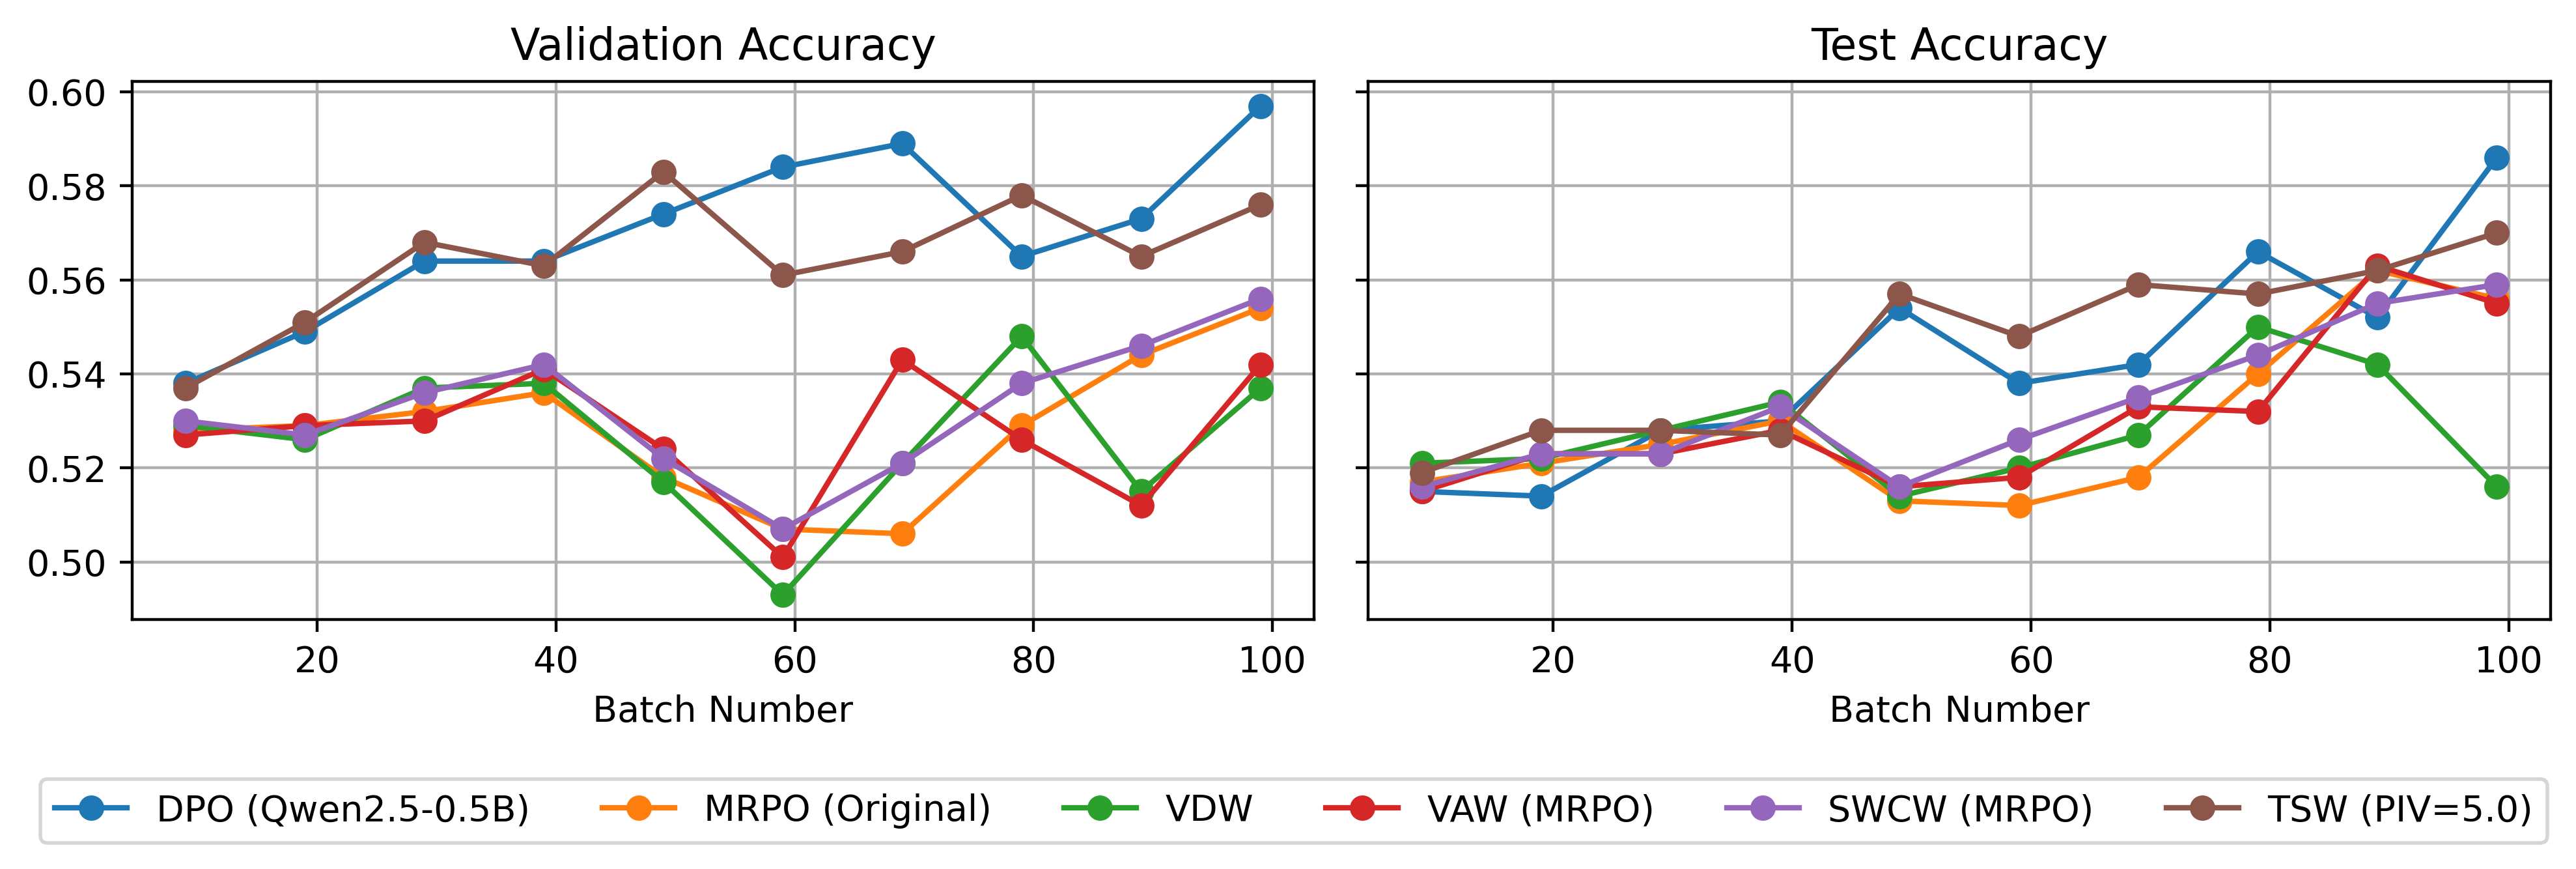

In [ ]:
'''
Order: DPO (7x), Original MRPO/MDPO, VDW MRPO/MDPO, VAW MRPO/MDPO, SWCW MRPO/MDPO, SWCW-OH, TSW 5.0/10.0
'''
# let's just look at one seed
SEED = 2

# create our subplots
fig, ax = plt.subplots(1, 2, dpi=400, figsize=(10, 3), sharex=True, sharey=True)

# get our representatives
dpo = pd.read_csv("raw_results/skyler/DPO_dataset=SafeRLHF_rm=Qwen2.5-0.5B_seed=2.csv")
mrpo = pd.read_csv("raw_results/aymen/SafeRLHF_Original_2_MRPO.csv")
vdw = pd.read_csv("raw_results/aymen/SafeRLHF_VDW_2_MRPO.csv")
vaw = pd.read_csv("raw_results/aymen/SafeRLHF_VAW_2_MRPO.csv")
swcw = pd.read_csv("raw_results/aymen/SafeRLHF_SWCW_2_MRPO.csv")
tsw = pd.read_csv("raw_results/skyler/TSW_dataset=SafeRLHF_PIV=5.0_seed=2.csv")

# 1. validation accuracy over time
ax[0].plot(dpo.val_acc.dropna(), marker="o", label="DPO")
ax[0].plot(
    mrpo.val_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in mrpo.val_acc.dropna()],
    marker="o", label="MRPO")
ax[0].plot(
    vdw.val_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in vdw.val_acc.dropna()],
    marker="o", label="VDW")
ax[0].plot(
    vaw.val_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in vaw.val_acc.dropna()],
    marker="o", label="VAW")
ax[0].plot(
    swcw.val_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in swcw.val_acc.dropna()],
    marker="o", label="SWCW")
ax[0].plot(tsw.val_acc.dropna(), marker="o", label="TSW")
ax[0].grid(); ax[0].set_title("Validation Accuracy"); ax[0].set_xlabel("Batch Number")

# 2. test accuracy over time
ax[1].plot(dpo.test_acc.dropna(), marker="o", label="DPO (Qwen2.5-0.5B)")
ax[1].plot(
    mrpo.test_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in mrpo.test_acc.dropna()],
    marker="o", label="MRPO (Original)")
ax[1].plot(
    vdw.test_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in vdw.test_acc.dropna()],
    marker="o", label="VDW")
ax[1].plot(
    vaw.test_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in vaw.test_acc.dropna()],
    marker="o", label="VAW (MRPO)")
ax[1].plot(
    swcw.test_acc.dropna().index,
    [float(v.split(", device")[0].split("tensor(")[1]) for v in swcw.test_acc.dropna()],
    marker="o", label="SWCW (MRPO)")
ax[1].plot(tsw.test_acc.dropna(), marker="o", label="TSW (PIV=5.0)")
ax[1].grid(); ax[1].set_title("Test Accuracy"); ax[1].set_xlabel("Batch Number")

# custom legend
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, ncol=6, bbox_to_anchor=(0.99, 0.01))

# beautify at the end
plt.tight_layout()
plt.savefig("figures/figure-2_instability-of-accuracy-metrics-vs-DPO_seed=2_SafeRLHF.pdf",
            bbox_inches="tight", facecolor="white")
plt.show()

# Appendix Figure 1: Instability Summary

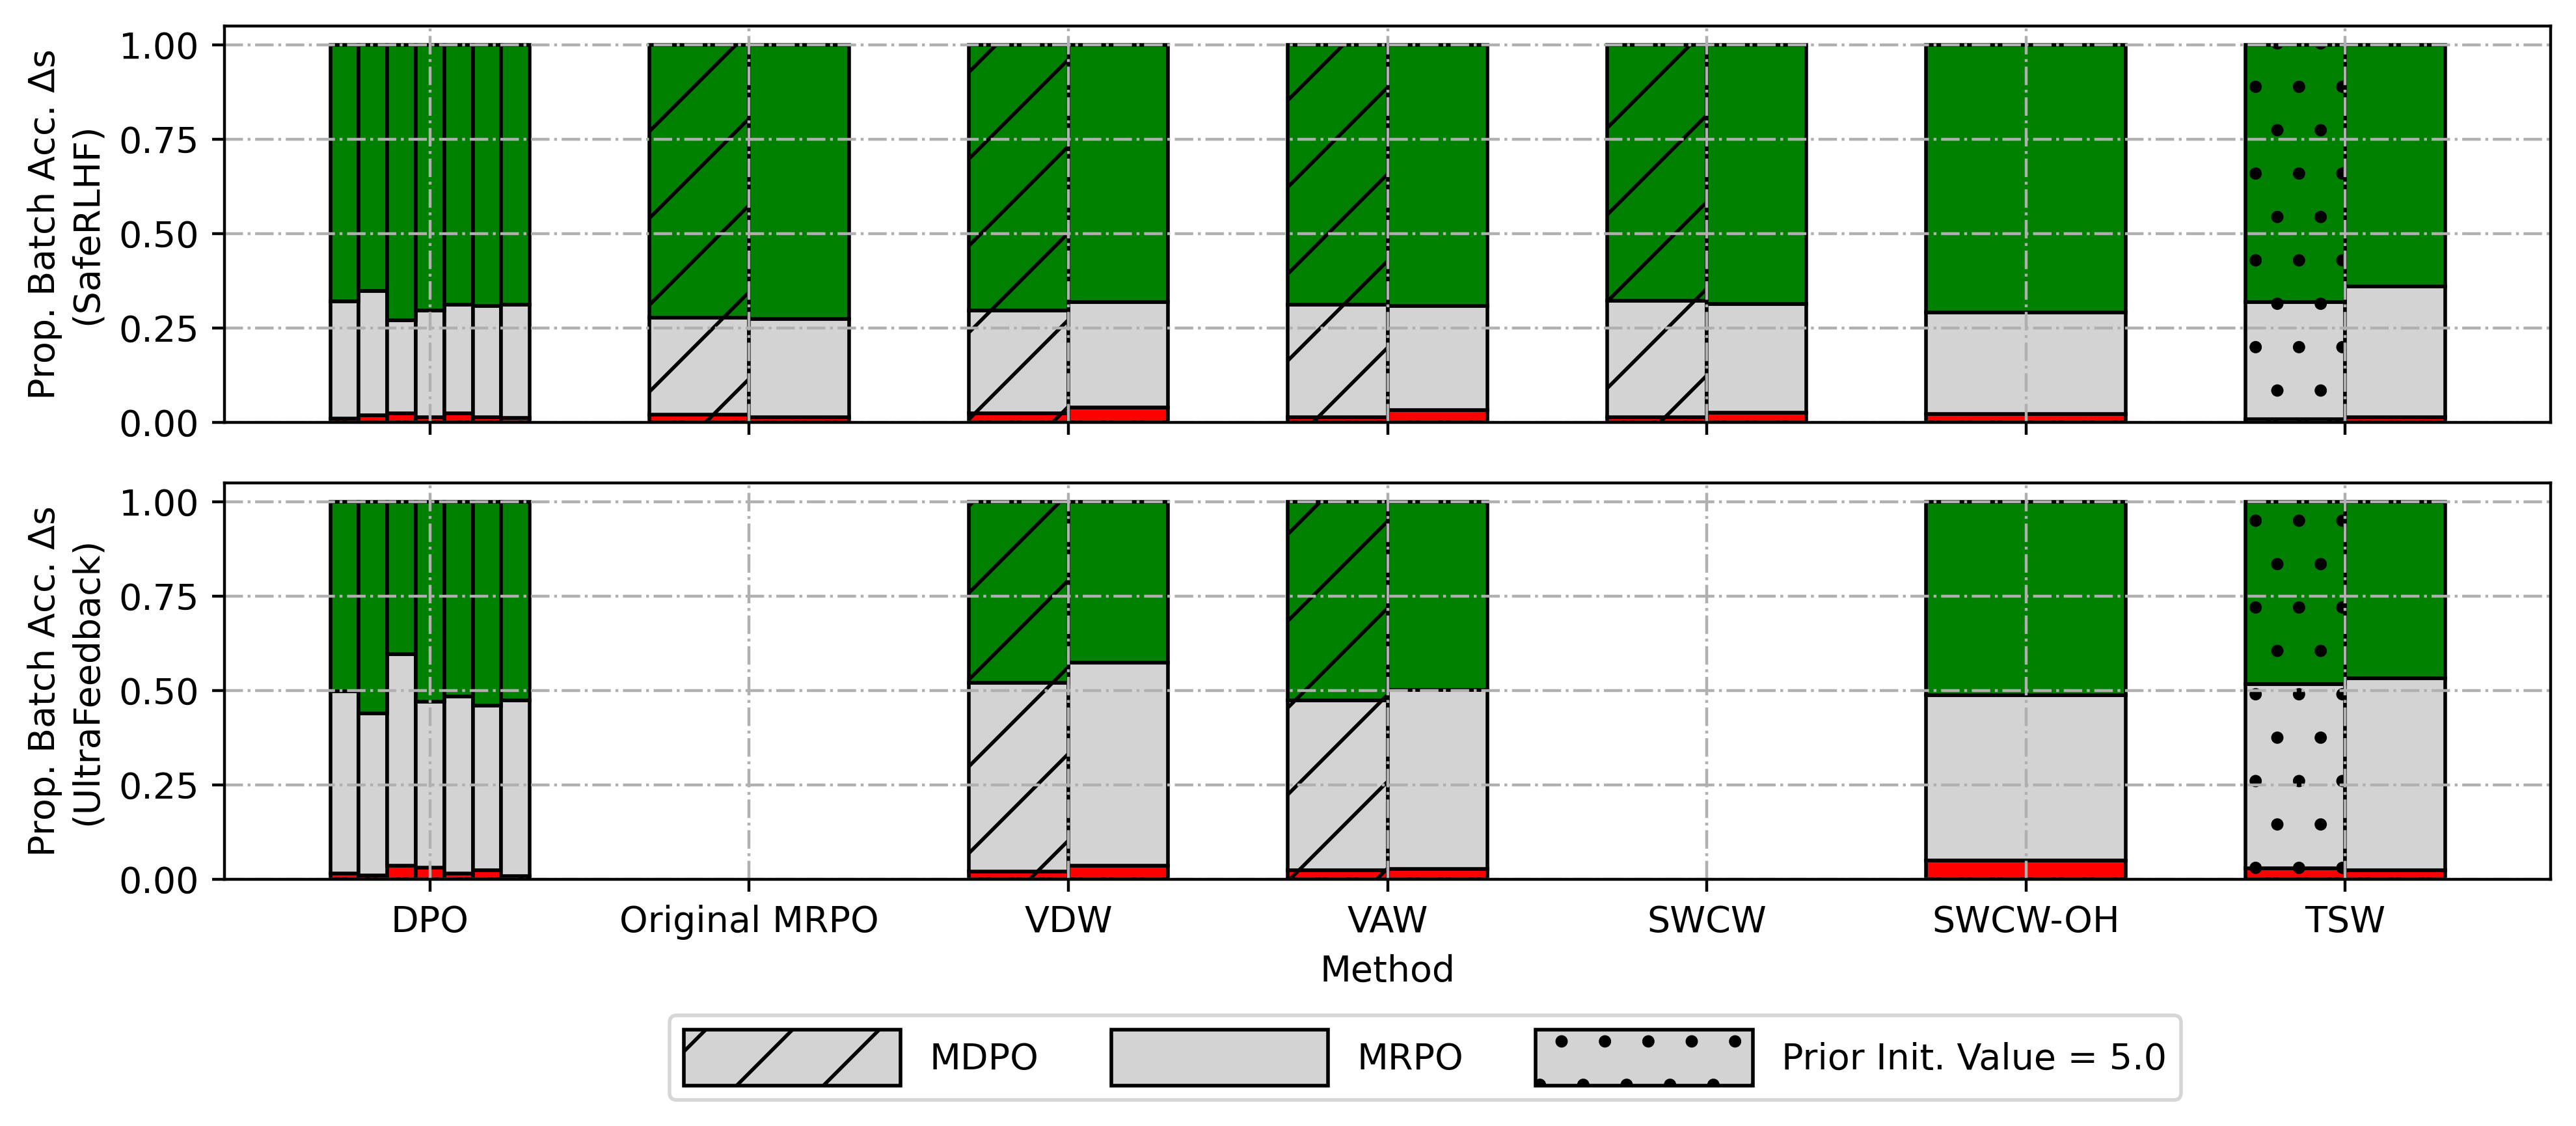

In [ ]:
'''
Order: DPO (7x), Original MRPO/MDPO, VDW MRPO/MDPO, VAW MRPO/MDPO, SWCW MRPO/MDPO, SWCW-OH, TSW 5.0/10.0
'''
# create our long subplots
fig, ax = plt.subplots(2, 1, dpi=400, figsize=(10, 4), sharex=True)

# go thru each dataset
for i, dataset in enumerate(["SafeRLHF", "UltraFeedback"]):

    # 1. assemble the mean accuracies and standard errors for each method

    ## DPO
    dpo_query = pd.read_csv("cleaned_results/dpo_summary.csv").groupby(["method", "dataset", "reference"])
    dpo_vals = dpo_query.mean().reset_index().query(f"dataset == '{dataset}'")\
    .set_index("reference").loc[REF_MODELS_TRUNC][["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
    bars1 = ax[i].bar(color="red", x=np.arange(-3, 3+1) / 14, height=dpo_vals[0], width=1/14, edgecolor="black")
    bars2 = ax[i].bar(color="lightgrey", x=np.arange(-3, 3+1) / 14, height=dpo_vals[1], bottom=dpo_vals[0], width=1/14, edgecolor="black")
    bars3 = ax[i].bar(color="green", x=np.arange(-3, 3+1) / 14, height=dpo_vals[2], bottom=dpo_vals[1] + dpo_vals[0], width=1/14, edgecolor="black")

    ## Original MDPO/MRPO
    if dataset == "SafeRLHF":

        # we're only doing this for SafeRLHF because UltraFeedback NaN'ed out.
        originals_query = pd.read_csv("cleaned_results/originals_summary.csv")\
        .groupby(["method", "dataset", "base"])
        originals_vals = originals_query.mean()[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T # order is MDPO/MRPO.
        bars1 = ax[i].bar(color="red", x=np.array([-0.125, +0.125]) + (0.8*1), height=originals_vals[0], width=0.25, edgecolor="black")
        bars2 = ax[i].bar(color="lightgrey", x=np.array([-0.125, +0.125]) + (0.8*1), height=originals_vals[1], bottom=originals_vals[0], width=0.25, edgecolor="black")
        bars3 = ax[i].bar(color="green", x=np.array([-0.125, +0.125]) + (0.8*1), height=originals_vals[2], bottom=originals_vals[0]+originals_vals[1], width=0.25, edgecolor="black")
        bars1[0].set_hatch("/")
        bars2[0].set_hatch("/")
        bars3[0].set_hatch("/")

    else:
        # put in a dummy
        ax[i].bar(x=[0.8*1], height=[np.nan])

    ## VDW MRPO/MDPO (Offline 1)
    vdw_query = pd.read_csv("cleaned_results/offlines_summary.csv")\
    .query(f"dataset == '{dataset}' and method == 'VDW'").groupby(["method", "dataset", "base"])
    vdw_vals = vdw_query.mean()[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
    bars1 = ax[i].bar(color="red", x=np.array([-0.125, +0.125]) + (0.8*2), height=vdw_vals[0], width=0.25, edgecolor="black")
    bars2 = ax[i].bar(color="lightgrey", x=np.array([-0.125, +0.125]) + (0.8*2), height=vdw_vals[1], bottom=vdw_vals[0], width=0.25, edgecolor="black")
    bars3 = ax[i].bar(color="green", x=np.array([-0.125, +0.125]) + (0.8*2), height=vdw_vals[2], bottom=vdw_vals[0]+vdw_vals[1], width=0.25, edgecolor="black")
    bars1[0].set_hatch("/")
    bars2[0].set_hatch("/")
    bars3[0].set_hatch("/")

    ## VAW MRPO/MDPO (Offline 2)
    vaw_query = pd.read_csv("cleaned_results/offlines_summary.csv")\
    .query(f"dataset == '{dataset}' and method == 'VAW'").groupby(["method", "dataset", "base"])
    vaw_vals = vaw_query.mean()[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
    bars1 = ax[i].bar(color="red", x=np.array([-0.125, +0.125]) + (0.8*3), height=vaw_vals[0], width=0.25, edgecolor="black")
    bars2 = ax[i].bar(color="lightgrey", x=np.array([-0.125, +0.125]) + (0.8*3), height=vaw_vals[1], bottom=vaw_vals[0], width=0.25, edgecolor="black")
    bars3 = ax[i].bar(color="green", x=np.array([-0.125, +0.125]) + (0.8*3), height=vaw_vals[2], bottom=vaw_vals[0]+vaw_vals[1], width=0.25, edgecolor="black")
    bars1[0].set_hatch("/")
    bars2[0].set_hatch("/")
    bars3[0].set_hatch("/")

    ## SWCW MRPO/MDPO (Online 1)
    if dataset == "SafeRLHF":

        # Online 1 only worked on SafeRLHF! UltraFeedback NaN'ed out.
        swcw_query = pd.read_csv("cleaned_results/online-1s_summary.csv")\
        .query(f"dataset == '{dataset}' and one_hot == False").groupby(["method", "dataset", "base"])
        swcw_vals = swcw_query.mean()[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
        bars1 = ax[i].bar(color="red", x=np.array([-0.125, +0.125]) + (0.8*4), height=swcw_vals[0], width=0.25, edgecolor="black")
        bars2 = ax[i].bar(color="lightgrey", x=np.array([-0.125, +0.125]) + (0.8*4), height=swcw_vals[1], bottom=swcw_vals[0], width=0.25, edgecolor="black")
        bars3 = ax[i].bar(color="green", x=np.array([-0.125, +0.125]) + (0.8*4), height=swcw_vals[2], bottom=swcw_vals[0]+swcw_vals[1], width=0.25, edgecolor="black")
        bars1[0].set_hatch("/")
        bars2[0].set_hatch("/")
        bars3[0].set_hatch("/")

    # put a dummy
    else:
        ax[i].bar(x=[0.8*4], height=[np.nan])

    ## SWCW-OH (Online 1, One-Hot Encoded) - only one variant!
    swcw_oh_query = pd.read_csv("cleaned_results/online-1s_summary.csv")\
    .query(f"dataset == '{dataset}' and one_hot == True").groupby(["method", "dataset", "base"])
    swcw_oh_vals = swcw_oh_query.mean()[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
    bars1 = ax[i].bar(color="red", x=[0.8*5], height=swcw_oh_vals[0], width=0.5, edgecolor="black")
    bars2 = ax[i].bar(color="lightgrey", x=[0.8*5], height=swcw_oh_vals[1], bottom=swcw_oh_vals[0], width=0.5, edgecolor="black")
    bars3 = ax[i].bar(color="green", x=[0.8*5], height=swcw_oh_vals[2], bottom=swcw_oh_vals[1] + swcw_oh_vals[0], width=0.5, edgecolor="black")

    ## Thompson (Online 2)
    tsw_query = pd.read_csv("cleaned_results/tsw_summary.csv").query(f"dataset == '{dataset}'").groupby(["method", "dataset", "piv"])
    tsw_vals = tsw_query.mean()[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
    bars1 = ax[i].bar(color="red", x=np.array([-0.125, +0.125]) + (0.8*6), height=tsw_vals[0], width=0.25, edgecolor="black")
    bars2 = ax[i].bar(color="lightgrey", x=np.array([-0.125, +0.125]) + (0.8*6), height=tsw_vals[1], bottom=tsw_vals[0], width=0.25, edgecolor="black")
    bars3 = ax[i].bar(color="green", x=np.array([-0.125, +0.125]) + (0.8*6), height=tsw_vals[2], bottom=tsw_vals[0]+tsw_vals[1], width=0.25, edgecolor="black")
    bars1[0].set_hatch("."); bars2[0].set_hatch("."); bars3[0].set_hatch(".")

    # 2. beautify
    ax[i].grid(linestyle="-.")
    ax[i].set_xticks(0.8 * np.arange(7))
    ax[i].set_xticklabels(["DPO", "Original MRPO", "VDW", "VAW", "SWCW", "SWCW-OH", "TSW"])

    # final beautifying
    if i == 1:
        ax[i].set_xlabel("Method")
    ax[i].set_ylabel(f"Prop. Batch Acc. $\Delta$s \n({dataset})")

# make a fake legend
handles = [
    Patch(facecolor="lightgrey", hatch="/", edgecolor="black", label="MDPO"),
    Patch(facecolor="lightgrey", edgecolor="black", label="MRPO"),
    Patch(facecolor="lightgrey", edgecolor="black", hatch=".", label="Prior Init. Value = 5.0")]
fig.legend(handles=handles, ncol=4, handlelength=6, handleheight=2, bbox_to_anchor=(0.85, +0.03))

# beautify
plt.tight_layout()
plt.savefig("figures/appendix-figure-1_delta-neg-zero-pos.pdf", bbox_inches="tight", facecolor="white")
plt.show()

# Table 1: Kendall's $\tau$ Statistics + Hypothesis Testing (Offline + DPO Special Case)

In [ ]:
# load in our offline 1+2 methods' summaries, DPO summaries
offlines_summary = pd.read_csv("cleaned_results/offlines_summary.csv")
dpo_summary = pd.read_csv("cleaned_results/dpo_summary.csv")

# Full names of our reference models
FULL_REF_MODELS = {
    "01-ai_Yi-1.5-9B-Chat" : "Yi-1.5-9B",
    "meta-llama_Meta-Llama-3.1-8B-Instruct" : "Llama-3.1-8B",
    "microsoft_Phi-3-medium-128k-instruct" : "Phi-3-Medium-128k",
    "mistralai_Mistral-7B-Instruct-v0.3" : "Mistral-7B",
    "Qwen_Qwen2.5-0.5B-Instruct" : "Qwen2.5-0.5B",
    "Qwen_Qwen2.5-1.5B-Instruct" : "Qwen2.5-1.5B",
    "Qwen_Qwen3-4B-Instruct-2507" : "Qwen3-4B"
}

# create a dataframe to store these reference models' test acc results
reference_logs = pd.DataFrame(data=None, columns=["dataset", "seed", "reference", "test_acc"])

# compute each reference models' test accuracies on SafeRLHF and UltraFeedback
for dataset, dataset_full in zip(
    ["SafeRLHF", "UltraFeedback"],
    ["PKU-SafeRLHF-30K-standard", "ultrafeedback_binarized"]):

    # go thru our five seeds
    for seed in range(5 if dataset == "SafeRLHF" else 3):

        # look inside the precomputed directory and see our reference models
        fnames = os.listdir(f"../cleaned/{dataset_full}/seed={seed}/precomputed")
        test_fnames = sorted([f for f in fnames if "test.csv" in f])

        # go thru our seven reference models
        for full_ref_model in FULL_REF_MODELS.keys():

            # get the easier name of the model
            reference = FULL_REF_MODELS[full_ref_model]

            # get the raw precomputed logits for this reference model
            logits = pd.read_csv(f"../cleaned/{dataset_full}/seed={seed}/precomputed/{full_ref_model}_test.csv")

            # get the test acc
            test_acc = ((logits.logprob_chosen / logits.L_chosen) > (logits.logprob_rejected / logits.L_rejected)).mean()

            # record in our dataframe
            reference_logs.loc[len(reference_logs.index)] = [dataset, seed, reference, test_acc]

# save our results to a .csv
reference_logs.to_csv("cleaned_results/reference_summary.csv", index=False)

In [ ]:
# kendall-tau logs for offline methods
kt_offline_logs = pd.DataFrame(
    data=None, columns=["dataset", "method", "seed", "kt_alpha_ref", "kt_alpha_dpo", "corr_dpo_ref"])

# go thru each dataset, each offline method
for dataset in ["UltraFeedback", "SafeRLHF"]:
    for method in ["VAW", "VDW"]:

        # how many seeds do we have?
        n_seeds = 5 if dataset == "SafeRLHF" else 3

        # go thru all the seeds
        for seed in range(n_seeds):

            # get the alphas for the seeds
            alphas = offlines_summary.query(
                f"method == '{method}' and dataset == '{dataset}' and base == 'MDPO' and seed == {seed}")\
            [[f"alpha_{i}" for i in range(7)]].values.flatten()

            # what is the true ordering of reference model test accuracies?
            reference_accs = reference_logs.query(f"dataset == '{dataset}' and seed == {seed}")\
            .set_index("reference").loc[REF_MODELS_TRUNC].test_acc.values

            # what is the true ordering of DPO-reference test accuracies?
            dpo_reference_accs = dpo_summary.query(f"dataset == '{dataset}' and seed == {seed}")\
            .set_index("reference").loc[REF_MODELS_TRUNC].final_test_acc.values

            # compute our Kendall-tau statistics (we'll permutation test for p-values) and correlations
            kt_alpha_ref = kendalltau(alphas, reference_accs)[0]
            kt_alpha_dpo = kendalltau(alphas, dpo_reference_accs)[0]
            corr_dpo_ref = np.corrcoef(reference_accs, dpo_reference_accs)[0,1]

            # add to our list
            row = [dataset, method, seed, kt_alpha_ref, kt_alpha_dpo, corr_dpo_ref]
            kt_offline_logs.loc[len(kt_offline_logs.index)] = row

In [ ]:
# get summaries of the correlation between DPO-reference-accuracy and reference-pretrained accuracy
print("Means of Correlation between DPO-Reference Accuracy and Reference-Pretrained Accuracy")
print(kt_offline_logs.query("method == 'VAW'").groupby(["dataset", "method"]).mean().corr_dpo_ref)

print("Standard Errors of Correlation between DPO-Reference Accuracy and Reference-Pretrained Accuracy")
print(
    kt_offline_logs.query("method == 'VAW'").groupby(["dataset", "method"]).std().corr_dpo_ref /
    np.sqrt(np.array([5.0, 3.0])))

Means of Correlation between DPO-Reference Accuracy and Reference-Pretrained Accuracy
dataset        method
SafeRLHF       VAW       0.254963
UltraFeedback  VAW       0.058896
Name: corr_dpo_ref, dtype: float64
Standard Errors of Correlation between DPO-Reference Accuracy and Reference-Pretrained Accuracy
dataset        method
SafeRLHF       VAW       0.101475
UltraFeedback  VAW       0.312985
Name: corr_dpo_ref, dtype: float64


In [ ]:
# hypothesis testing on Kendall-Tau (we'll put these mean values as a table in our paper)
print(kt_offline_logs.groupby(["dataset", "method"]).mean())

                      seed  kt_alpha_ref  kt_alpha_dpo  corr_dpo_ref
dataset       method                                                
SafeRLHF      VAW      2.0      0.481365      0.017151      0.254963
              VDW      2.0     -0.109466     -0.457348      0.254963
UltraFeedback VAW      1.0      0.396825      0.174603      0.058896
              VDW      1.0     -0.015873     -0.301587      0.058896


In [ ]:
# permutation tests to get distribution of Kendall tau p-values (symmetric permutations!)
np.random.seed(858); B = 100000 # number of permutation samples to draw

# set our ground truth WLOG to be sequential
perm_true = np.arange(7, dtype=int)

# get our permutation distribution of Kendall-Tau statistics under random guessing
kt_perm_distro = np.array(
    [[kendalltau(np.random.permutation(7), perm_true)[0] for b in tqdm(range(B))] for s in range(5)])

In [ ]:
# compute the CDFs for seeds=3 vs. seeds=5
ECDF_n5 = ecdf(kt_perm_distro.mean(axis=0))
ECDF_n3 = ecdf(kt_perm_distro[:3,:].mean(axis=0))

In [ ]:
# p-values for the 4x SafeRLHF values
1.0 - ECDF_n5.cdf.evaluate(kt_offline_logs.groupby(["dataset", "method"]).mean()\
                           [["kt_alpha_ref", "kt_alpha_dpo"]].loc["SafeRLHF"])

array([[2.6000e-04, 4.4380e-01],
       [7.8803e-01, 9.9958e-01]])

In [ ]:
# p-values for the 4x UltraFeedback values
1.0 - ECDF_n3.cdf.evaluate(kt_offline_logs.groupby(["dataset", "method"]).mean()\
                           [["kt_alpha_ref", "kt_alpha_dpo"]].loc["UltraFeedback"])

array([[0.01167, 0.15099],
       [0.50871, 0.94396]])

# Figure 4: Online I Heatmaps

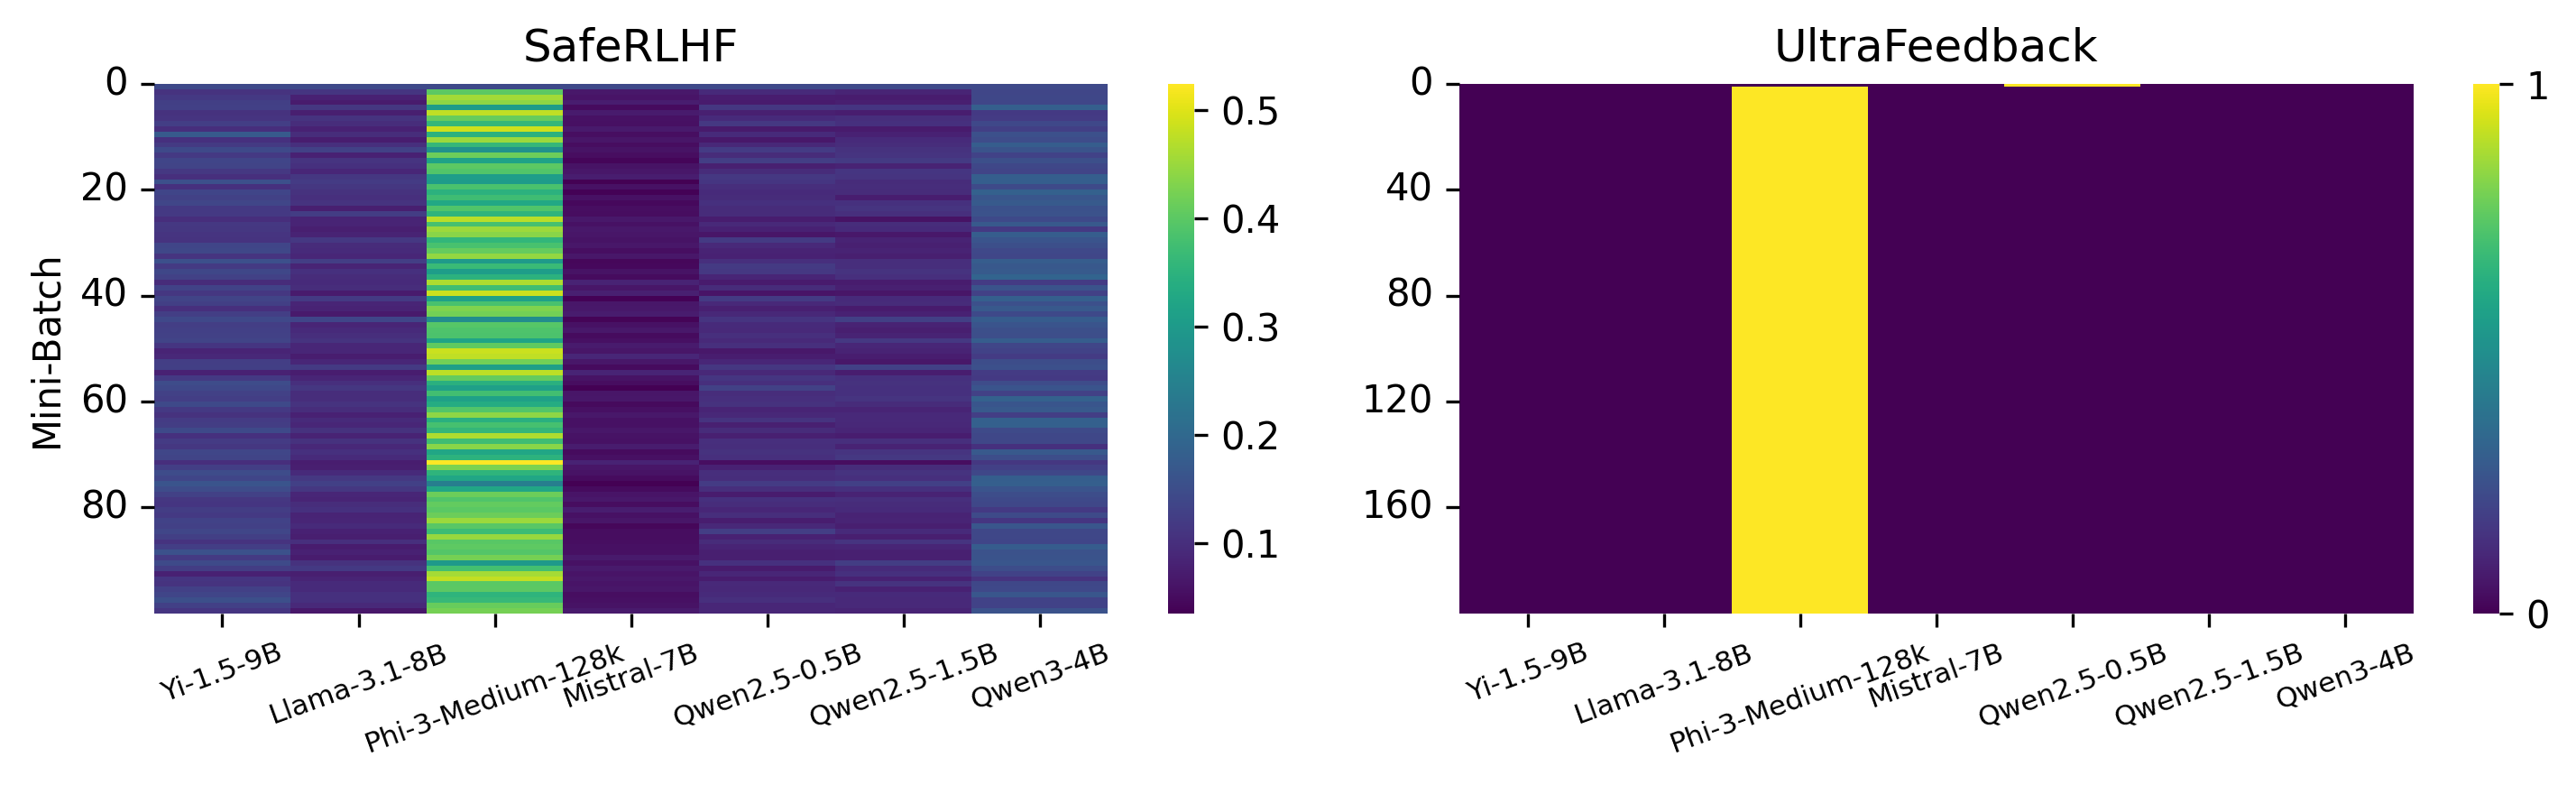

In [ ]:
# create our subplots
fig, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 3))

# we can skip the SWCW-OH version of SafeRLHF because it's pretty clear it'll be just 0-1.
swcw_saferlhf = pd.read_csv("raw_results/aymen/SafeRLHF_SWCW_2_MDPO.csv")
sns.heatmap(swcw_saferlhf[[col for col in swcw_saferlhf.columns if "alpha" in col]].values, ax=ax[0], cmap="viridis")
ax[0].set_title("SafeRLHF"); ax[0].set_xticklabels(REF_MODELS_TRUNC, fontsize=7.5, rotation=20)
ax[0].set_yticks(np.arange(0, 100, 20)); ax[0].set_yticklabels(np.arange(0, 100, 20))
ax[0].set_ylabel("Mini-Batch")

swcw_oh_uf = pd.read_csv("raw_results/skyler/SWCW-OH_dataset=UltraFeedback_seed=2.csv").chosen_reference
chosen = np.zeros(shape=(200, 7))
chosen[swcw_oh_uf.index, swcw_oh_uf.values.astype(int)] = 1.0
sns.heatmap(chosen, ax=ax[1], cbar_kws={"ticks": [0, 1]}, cmap="viridis")
ax[1].set_title("UltraFeedback"); ax[1].set_xticklabels(REF_MODELS_TRUNC, fontsize=7.5, rotation=20)
ax[1].set_yticks(np.arange(0, 200, 40)); ax[1].set_yticklabels(np.arange(0, 200, 40))

# beautify
plt.tight_layout()
plt.savefig("figures/figure-3_online-1_alphas-over-time_seed=2.pdf", bbox_inches="tight", facecolor="white")
plt.show()

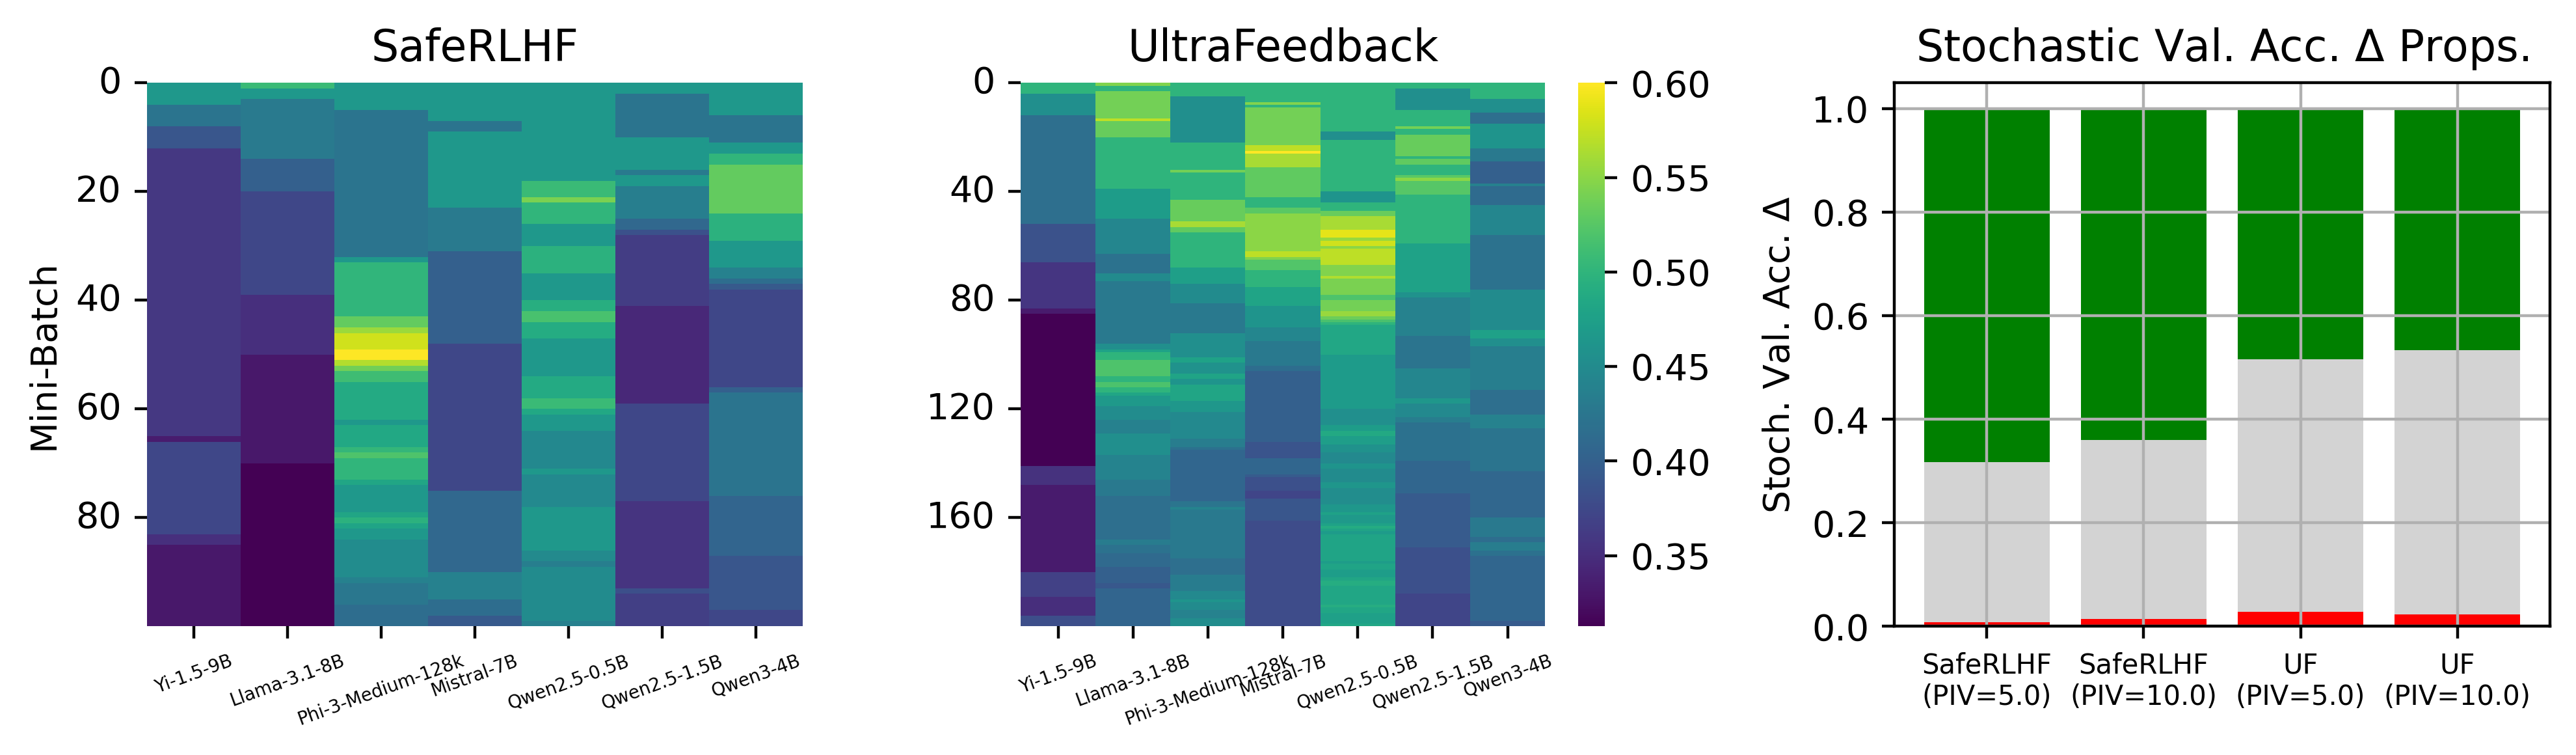

In [ ]:
# get columns for the a's and the b's
a, b = [f"a{i}" for i in range(7)], [f"b{i}" for i in range(7)]

# load in our data
tsw_saferlhf = pd.read_csv("raw_results/skyler/TSW_dataset=SafeRLHF_PIV=5.0_seed=0.csv")
tsw_uf = pd.read_csv("raw_results/skyler/TSW_dataset=UltraFeedback_PIV=5.0_seed=0.csv")

# also load in our TSW summary logs
tsw_summary = pd.read_csv("cleaned_results/tsw_summary.csv")

# get our mus for saferlhf and uf
mus_saferlhf = tsw_saferlhf[a].values / (tsw_saferlhf[a].values + tsw_saferlhf[b].values)
mus_uf = tsw_uf[a].values / (tsw_uf[a].values + tsw_uf[b].values)

# Figure 5: Online 2 mu's over time, also bar plots of stochastic val acc Deltas
fig, ax = plt.subplots(1, 3, dpi=400, figsize=(10, 3))

# heatmap for saferlhf and ultrafeedback
sns.heatmap(mus_saferlhf, ax=ax[0], cmap="viridis", edgecolor="black", cbar=False)
sns.heatmap(mus_uf, ax=ax[1], cmap="viridis", edgecolor="black")

# get our mean delta's on the stochastic validation set
deltas = tsw_summary.groupby(["method", "dataset", "piv"]).mean()\
[["prop_delta_neg", "prop_delta_zero", "prop_delta_pos"]].values.T
ax[2].bar(x=[0, 1, 2, 3], height=deltas[0], color="red")
ax[2].bar(x=[0, 1, 2, 3], height=deltas[1], bottom=deltas[0], color="lightgrey")
ax[2].bar(x=[0, 1, 2, 3], height=deltas[2], bottom=deltas[0] + deltas[1], color="green")
ax[2].set_xticks([0, 1, 2, 3]); ax[2].grid(); ax[2].set_ylabel("Stoch. Val. Acc. $\Delta$")
ax[2].set_title("Stochastic Val. Acc. $\Delta$ Props.")
ax[2].set_xticklabels(["SafeRLHF\n(PIV=5.0)", "SafeRLHF\n(PIV=10.0)",
                       "UF\n(PIV=5.0)", "UF\n(PIV=10.0)"], fontsize=7.5)

# beautifying
ax[0].set_title("SafeRLHF"); ax[0].set_ylabel("Mini-Batch")
ax[0].set_yticks(np.arange(0, 100, 20)); ax[0].set_yticklabels(np.arange(0, 100, 20))
ax[0].set_xticklabels(REF_MODELS_TRUNC, fontsize=5, rotation=20)
ax[1].set_title("UltraFeedback")
ax[1].set_yticks(np.arange(0, 200, 40)); ax[1].set_yticklabels(np.arange(0, 200, 40))
ax[1].set_xticklabels(REF_MODELS_TRUNC, fontsize=5, rotation=20)

# overall beautifying
plt.tight_layout()
plt.savefig(
    "figures/figure-4_online-2_alphas-over-time+stoch-val-acc-delta.pdf",
    facecolor="white", bbox_inches="tight")
plt.show()

In [ ]:
# columns for getting the mu_i
mu_cols = [f"mu_{i}" for i in range(7)]

# dataframe to store our results for Kendall-Tau on Online 2
kt_logs_o2 = pd.DataFrame(data=None, columns=["dataset", "piv", "seed", "kt_mu_dpo", "kt_mu_ref"])

# kendall-tau summaries of Online-2 alphas vs. {DPO accuracies, reference model accuracies}
for dataset in ["UltraFeedback", "SafeRLHF"]:
    for PIV in [5.0, 10.0]:

        # how many seeds do we have?
        n_seeds = 5 if dataset == "SafeRLHF" else 3

        # go thru the seeds
        for seed in range(n_seeds):

            # get the final learned means
            mus = tsw_summary.query(
                f"dataset == '{dataset}' and piv == {PIV} and seed == {seed}")[mu_cols].values[0]

            # get the corresponding DPO accuracies for this dataset + seed
            dpo_accs = dpo_summary.pivot(
                index=["dataset", "seed"], values="final_test_acc", columns="reference")\
            [REF_MODELS_TRUNC].loc[(dataset, seed)].values

            # get the corresponding reference model accuracies for this dataset + seed
            ref_accs = reference_logs.pivot(index=["dataset", "seed"], columns="reference", values="test_acc")\
            [REF_MODELS_TRUNC].loc[(dataset, seed)].values

            # compute our kendall-taus + add to the list
            kt_mu_dpo = kendalltau(mus, dpo_accs)[0]
            kt_mu_ref = kendalltau(mus, ref_accs)[0]
            kt_logs_o2.loc[len(kt_logs_o2.index)] = [dataset, PIV, seed, kt_mu_dpo, kt_mu_ref]

In [ ]:
# show our results
kt_logs_o2.groupby(["dataset", "piv"]).mean()

seed  kt_mu_dpo  kt_mu_ref
dataset       piv                             
SafeRLHF      5.0    2.0  -0.018378   0.000000
              10.0   2.0   0.278351  -0.098060
UltraFeedback 5.0    1.0  -0.142857  -0.047619
              10.0   1.0  -0.142857   0.333333

In [ ]:
# p-values for the 4x SafeRLHF values
1.0 - ECDF_n5.cdf.evaluate(kt_logs_o2.groupby(["dataset", "piv"]).mean()
                           [["kt_mu_dpo", "kt_mu_ref"]].loc["SafeRLHF"])

array([[0.55028, 0.49782],
       [0.02101, 0.74664]])

In [ ]:
# p-values for the 4x UltraFeedback values
1.0 - ECDF_n3.cdf.evaluate(kt_logs_o2.groupby(["dataset", "piv"]).mean()
                           [["kt_mu_dpo", "kt_mu_ref"]].loc["UltraFeedback"])

array([[0.757  , 0.58491],
       [0.757  , 0.02865]])